In [16]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.special as spec
import scipy.integrate as integrate
import scipy.optimize as opt
#data array

#burrell data
Experimental = np.array(
                #burrell
                [('burrell', 'C40+ optical', 99.99, 145, 1.168, 1), ('benhelm', 'C40+ optical', 99.925, 3000, 1.168, 1), ('myerson', 'C40+ optical', 99.991, 145, 1.168, 1),],

            #fidelity the average is for the two states (burrell)
            dtype=[('author', np.string_), ('ion', np.string_), ('fidelity', 'float'), ('readout time(us)', 'float'), ('coherence T1(s)', 'U8'), ('coherence T2(ms)','U8')])

print(Experimental)

[(b'', b'', 99.99 ,  145., '1.168', '1')
 (b'', b'', 99.925, 3000., '1.168', '1')
 (b'', b'', 99.991,  145., '1.168', '1')]


In [17]:
'''In general, the rates for pumping between the qubit states will not be zero. For the
calcium optical qubit the |B〉→|D〉 pumping rate remains negligible (section 4.3.3), but
the rate of |D〉→|B〉pumping due to decay from the metastable D5/2 state is appreciable
at 1/τ where τ = 1.168(7) s is the average lifetime of the shelf state [138].
The count distribution B0(n) for trials prepared in the |B〉 state remains Poisson 
distributed with mean (RB + RD)tb, but the distribution for trials initially prepared in
the |D〉 state is modified to contain two terms:'''

'In general, the rates for pumping between the qubit states will not be zero. For the\ncalcium optical qubit the |B〉→|D〉 pumping rate remains negligible (section 4.3.3), but\nthe rate of |D〉→|B〉pumping due to decay from the metastable D5/2 state is appreciable\nat 1/τ where τ = 1.168(7) s is the average lifetime of the shelf state [138].\nThe count distribution B0(n) for trials prepared in the |B〉 state remains Poisson \ndistributed with mean (RB + RD)tb, but the distribution for trials initially prepared in\nthe |D〉 state is modified to contain two terms:'

In [18]:
'''The number of counts n recorded in tb when an ion decays at a time t is Poisson distributed with mean λ(t)'''

#functions

def Bmean(RB, RD, tb):
    x = (RB+RD)*tb
    return x

def Dmean(RD, tb):
    x = RD*tb
    return x

def Bo(N, Bmean):
    x = (np.power(Bmean,N)) * (np.exp(-1*Bmean)) / spec.factorial(N)
    return x    

def Do(N, Dmean,RB,RD,tb,tau):
    x = (np.exp(-1*tb/tau)*(np.power(Dmean,N))*(np.exp(-1*Dmean)) / spec.factorial(N)) + Xo(N,RB,RD,tb,tau)
    print(x)
    return x

def Xo(N,RB,RD,tb,tau):
    X0 = []
    for n in N:
        X0 = np.append(X0, (integrate.quad(X_integrand, RD*tb, (RB+RD)*tb, args=(n,RB,RD,tau,tb)))[0])
    print(X0)
    return X0

def X_integrand(l,n,RB,RD,tau,tb):
    return (1/(RB*tau))*np.exp((l-((RD+RB)*tb))/(RB*tau))*np.power(l,n)*np.exp(-1*l)/spec.factorial(n)


[1.40549521e-05 1.40917503e-05 1.41275817e-05 ... 1.47266899e-11
 1.45735991e-11 1.44220557e-11]
[9.15251834e-01 8.98414066e-01 8.81743101e-01 ... 1.47266899e-11
 1.45735991e-11 1.44220557e-11]
99.99949146381637


Text(0.5, 1.0, 'Count Probability Including |D> to |B> Decay at Bin Time 0.0002s')

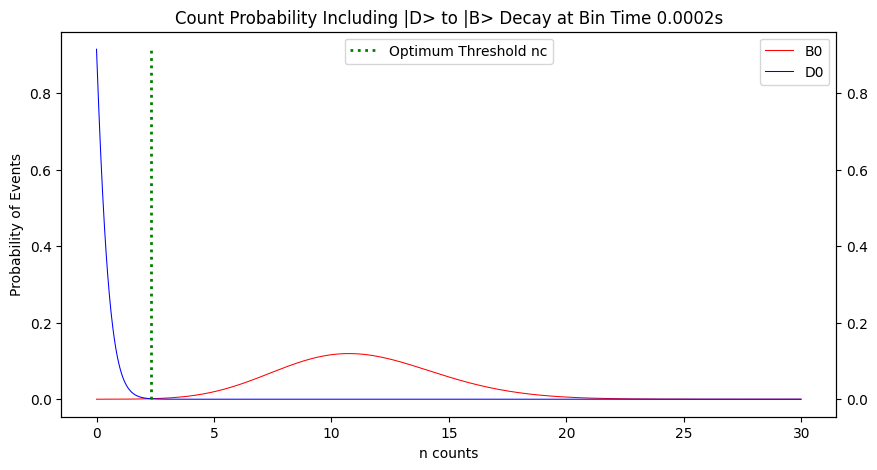

In [19]:
#Variables

#Burrell quoted
#RB = 55800 s−1
#RD = 442 s−1
#tb = 420 us = .00042

#nc = diferentiation counts

#n = counts
nMax = 30
#Bright state fluoresence rate
Rb = 55800
#Dark state fluoresence rate
Rd = 442
#bin time
tb = .0002
#tau decay time for Ca40
tau = 1.167

step = .01
N = np.arange(start=0,stop=nMax,step=step)

#Graphing
Bmean = Bmean(Rb,Rd,tb)
BM = np.full(np.int_(nMax/step),Bmean)
Dmean = Dmean(Rd,tb)

#n counts in tb from bright
B0 = Bo(N,BM)
#print(N)
#print(B0)
#n counts in tb from dark
D0 = Do(N,Dmean,Rb,Rd,tb,tau)

#B0 = B0/np.sum(B0)
#D0 = D0/np.sum(D0)
#count threshold
nc = 0
minDiff = np.abs(B0[0]-D0[0])
for i, item in enumerate(B0):
    diff = np.abs(B0[i]-D0[i])
    if(i < np.size(B0)/2 and diff<minDiff):
        nc = i
        minDiff = diff
nc=nc*step
print(np.sum(B0))


fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(N, B0, lw=0.75, c="r", label = "B0")
ax1.set_ylabel("Probability of Events")
ax1.set_xlabel("n counts")
ax1.plot(N, D0, lw=0.75, c="b", label = "D0")
ax3 = plt.twinx(ax1)
plt.vlines(nc, ymin=0, ymax=np.max(D0), colors='green', ls=':', lw=2, label='Optimum Threshold nc')
ax1.legend(loc = 'upper right')
ax3.legend(loc = 'upper center')
plt.title("Count Probability Including |D> to |B> Decay at Bin Time "+ str(tb)+"s")

In [20]:
#Optimal Time vs Collection Efficiency Discrete

#Find error at a specific bin time and n count

Rb = 55800
Rd = 442
#bin time
tb = .00042
#optimal count nc
tau = 1.168 #s for Ca40


#integrate D over n's @tb
def ed(tb): 
    return integrate.quad(D_integrand, nc, nc*10, args=(Rd,Rb,tb,tau))[0]

def D_integrand(n,Rd,Rb,tb,tau):
    return ((np.exp(-1*tb/tau)*(np.power(Dmean,n))*(np.exp(Dmean)) / spec.factorial(n)) + (integrate.quad(X_integrand, Rd*tb, (Rb+Rd)*tb, args=(n,Rb,Rd,tau,tb)))[0])

#integrate X over lambda's
def X_integrand(l,n,Rb,Rd,tau,tb):
    return (1/(Rb*tau))*np.exp((l-((Rd+Rb)*tb))/(Rb*tau))*np.power(l,n)*np.exp(-1*l)/spec.factorial(n)


#0 to nc w/ B0
def eb(tb,Rb,Rd):
    return (integrate.quad(B_integrand, 0, nc, args=(Rb, Rd, tb))[0])

def B_integrand(Rb, Rd, tb, n):
    return (np.power((Rb+Rd)*tb,n)) * (np.exp(-1*((Rb+Rd)*tb))) / spec.factorial(n)

tb = np.arange(start=.00001,stop=tb*2,step=.00001)
#print(tb)

darkE = np.empty(0)
brightE = np.empty(0)

for i in tb:
    darkE = np.append(darkE, ed(i))
for i in tb:
    brightE = np.append(brightE, eb(i))

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(tb, darkE, lw=0.75, c="r", label = "D0")
ax1.set_ylabel("Error")
ax1.set_xlabel("Bin Time (s)")
ax1.plot(tb, brightE, lw=0.75, c="b", label = "B0")
ax1.legend(loc = 'upper center')
plt.title("Dark and Bright Errors Finite Lifetime ")

TypeError: eb() missing 2 required positional arguments: 'Rb' and 'Rd'

In [ ]:
#Optimal Bin Time vs Collection Efficiency

#Find error at a specific bin time and n count

Rb = 55800
Rd = 442
#bin time
tb = .00042
#optimal count nc
tau = 1.168 #s for Ca40


#integrate D over n's @tb
def ed(tb): 
    return integrate.quad(D_integrand, nc, nc*10, args=(Rd,Rb,tb,tau))[0]

def D_integrand(n,Rd,Rb,tb,tau):
    return ((np.exp(-1*tb/tau)*(np.power(Dmean,n))*(np.exp(Dmean)) / spec.factorial(n)) + (integrate.quad(X_integrand, Rd*tb, (Rb+Rd)*tb, args=(n,Rb,Rd,tau,tb)))[0])

#integrate X over lambda's
def X_integrand(l,n,Rb,Rd,tau,tb):
    return (1/(Rb*tau))*np.exp((l-((Rd+Rb)*tb))/(Rb*tau))*np.power(l,n)*np.exp(-1*l)/spec.factorial(n)


#0 to nc w/ B0
def eb(tb,Rb,Rd):
    return (integrate.quad(B_integrand, 0, nc, args=(Rb, Rd, tb))[0])

def B_integrand(Rb, Rd, tb, n):
    return (np.power((Rb+Rd)*tb,n)) * (np.exp(-1*((Rb+Rd)*tb))) / spec.factorial(n)

tb = np.arange(start=.00001,stop=tb*2,step=.00001)
#print(tb)

darkE = np.empty(0)
brightE = np.empty(0)

for i in tb:
    darkE = np.append(darkE, ed(i))
for i in tb:
    brightE = np.append(brightE, eb(i))

darkE=darkE*100
brightE=brightE*100

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(tb, darkE, lw=0.75, c="r", label = "D0")
ax1.set_ylabel("Error")
ax1.set_xlabel("Bin Time (s)")
ax1.plot(tb, brightE, lw=0.75, c="b", label = "B0")
ax1.legend(loc = 'upper center')
plt.title("Dark and Bright Errors Finite Lifetime ")
